# Sentiment Analysis of Tweets using the Sentiment140 Dataset

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [3]:
# Import Dataset
data = pd.read_csv('sentiment140.csv', encoding='latin-1')
data.columns = ['sentiment','id','date','query','user','text']
data.head()

,sentiment,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
data.shape

(1599999, 6)

In [5]:
data.isnull().sum()

sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64

In [6]:
data.duplicated().sum()

np.int64(0)

In [7]:
data['sentiment'].value_counts()

sentiment
4    800000
0    799999
Name: count, dtype: int64

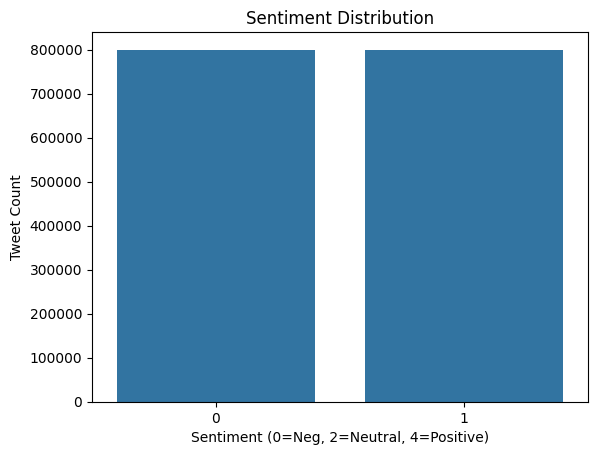

In [33]:
sns.countplot(x='sentiment', data=data)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment (0=Neg, 2=Neutral, 4=Positive)")
plt.ylabel("Tweet Count")
plt.show()

In [8]:
data = data[['sentiment', 'text']]
data['sentiment'] = data['sentiment'].apply(lambda x : 1 if x == 4 else 0)  # 1 = positive 0 = negative
data.head()

,sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [9]:
data['sentiment'].value_counts()

sentiment
1    800000
0    799999
Name: count, dtype: int64

In [10]:
# Text Cleaning
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text) # Remove URLs
    text = re.sub(r"@\w+", "", text)                    # Remove mentions
    text = text.lower()
    return text

In [11]:
data['clean_text'] = data['text'].apply(clean_text)
data.head()

,sentiment,text,clean_text
0,0,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball. managed to s...
2,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am..."
4,0,@Kwesidei not the whole crew,not the whole crew


In [12]:
# To create neutral sentiments
analyzer = SentimentIntensityAnalyzer()

In [13]:
def get_vader_label(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.3:
        return "positive"
    elif score <= -0.3:
        return "negative"
    else:
        return "neutral"  

In [14]:
data['final_sentiment'] = data['clean_text'].apply(get_vader_label)

In [15]:
# Balance the Dataset
min_size = data["final_sentiment"].value_counts().min()
data_balanced = (
    data.groupby("final_sentiment", group_keys=False)
      .sample(min_size, random_state=42)
)

In [16]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(data_balanced["clean_text"], 
                                                    data_balanced["final_sentiment"], 
                                                    test_size = 0.2, random_state = 42, 
                                                   stratify=data_balanced["final_sentiment"])  

In [17]:
# Convert text -> Numbers
vectorizer = CountVectorizer(max_features=60000, ngram_range=(1, 2), stop_words="english")

In [18]:

x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

In [19]:
# Model Fitting
model = MultinomialNB(alpha= 0.3)
model.fit(x_train_vec, y_train)

,alpha,0.3
,force_alpha,True
,fit_prior,True
,class_prior,None


In [20]:
# Prediction
y_pred = model.predict(x_test_vec)

In [21]:
# Calculate Accuracy
print(accuracy_score(y_test, y_pred))

0.7426307928986109


In [22]:
# Predict sentiment for new text
def predict_sentiment(text):
    text = clean_text(text)
    vec = vectorizer.transform([text])
    return model.predict(vec)[0]

print(predict_sentiment("I absolutely love this product"))
print(predict_sentiment("This phone is okay, nothing special"))
print(predict_sentiment("Worst experience ever"))

positive
positive
negative


In [23]:
print(predict_sentiment("I love this product, it works perfectly"))

positive


In [24]:
print(predict_sentiment("This is the best experience I have ever had"))

positive


In [25]:
print(predict_sentiment("The meeting is scheduled for tomorrow"))

neutral


In [26]:
print(predict_sentiment("The service was slow and disappointing"))

negative


In [27]:
print(predict_sentiment("I am unhappy with the quality"))

negative


In [28]:
print(predict_sentiment("I am enjoying wathing cricket"))

positive
